In [ ]:
import osmnx as ox
import geopandas as gpd
from shapely import Point, LineString, Polygon, MultiPoint
import numpy as np
import matplotlib.pyplot as plt

### querying overpass api

In [ ]:
### querying 
overpass_url = "https://overpass-api.de/api/interpreter"
overpass_query = '''
[out:json];
area[name="London"]->.a;
(
  node(area.a)["shop"~"party|pyrotechnics"];
  node(area.a)[amenity=hospital];
);
out;
'''

response = requests.post(overpass_url, data=overpass_query)
if response.status_code == 200:
    data=response.json()
    if len(data['elements'])!=0:
        df = pd.DataFrame(data['elements'])
        df = pd.concat([df.drop(columns='tags'),df['tags'].apply(pd.Series)], axis=1)
        df['geometry'] = df.apply(lambda row: Point(row['lon'], row['lat']), axis=1)
        gdf = gpd.GeoDataFrame(df, crs=4326)
        gdf['venue'] = pd.Series()
        gdf.loc[gdf['amenity'] == 'hospital', 'venue'] = 'hospital'
        gdf.loc[gdf['shop'] == 'party', 'venue'] = 'party shop'
        gdf.loc[gdf['shop'] == 'pyrotechnics', 'venue'] = 'fireworks shop'
    else:
        print('bugger')
else:
    print(f'no luck: {response.status_code}')

## inversions

In [ ]:

def inverse_point(p,origin,poly):
    a = (p.x-origin.x, p.y-origin.y) # vector from origin to p
    
    # extend vector to edge of poly
    factor=2
    newp = Point(origin.x + factor*a[0], origin.y + factor*a[1])
    while poly.contains(newp):
        factor *= 2
        newp = Point(origin.x + factor*a[0], origin.y + factor*a[1])
    to_edge = LineString([origin,newp]).intersection(poly)
    
    q = to_edge.length * 1 / to_edge.project(p,normalized=True)
    # print(q)
    # p_prime = Point(origin.x + q*a[0], origin.y + q*a[1])
    
    # proper inversion
    r = to_edge.length
    q = r**2 / np.hypot(*a)
    p_prime = Point(q * np.sin(np.arctan2(*a)),
                    q * np.cos(np.arctan2(*a))
                    )
        
    return p_prime
    
    
    def inverse_linestring(ls,origin,poly):    
    ps = [Point(p) for p in ls.coords]
    primes = [inverse_point(p,origin, poly) for p in ps]
    return LineString(primes)

In [ ]:
cntr = Point(0,0)
poly = cntr.buffer(10)
xy = -10 + (np.random.random((10,2))*20)
ps = [Point(p) for p in xy if poly.contains(Point(p))]
poly2 = Point(0,3).buffer(3)
x,y = poly2.exterior.coords.xy
ps = [Point(p) for p in zip(x,y)]

invert = [inverse_point(p,cntr,poly) for p in ps]

In [ ]:

fig,ax=plt.subplots()

ax.plot(*poly.exterior.coords.xy, label='reference')
ax.scatter(cntr.x,cntr.y, marker='*', s=50,c='k', label='origin')

# _ =[ax.plot(*ls.coords.xy) for ls in to_edges]
# _=[ax.scatter(p.x,p.y, s=5) for p in ps]
ax.plot(*LineString(ps).coords.xy, label='feature')


# _=[ax.scatter(p.x,p.y, marker='^',s=20) for p in invert]
ax.plot(*LineString(invert).coords.xy, label='inverted feature')

# _=[ax.plot(*l.coords.xy) for l in ls]
ax.set_aspect('equal')
ax.set_xlim(-20,20)

ax.legend()


In [ ]:
ls = LineString([[-3,1],[2,5],[4,6]])
inverse_ls = inverse_linestring(ls, cntr, poly)

fig,ax=plt.subplots()
ax.plot(*poly.exterior.coords.xy)
ax.plot(*ls.coords.xy)
ax.plot(*inverse_ls.coords.xy, c='g', linestyle=':')
ax.scatter(*cntr.coords.xy,marker='*')
ax.set_aspect('equal')

## osm query

In [ ]:
query = ox.features_from_place('South Downs National Park', tags={'type':'boundary',
                                                                  'boundary':'protected_area',
                                                                  'designation':'national_park',
                                                                  'name':'South Downs National Park',
                                                                  'wikidata':'Q3695606'
                                                                  })

sdnp = query.loc[(query['type']=='boundary') &
                 (query['boundary']=='protected_area') &
                 (query['designation']=='national_park') &
                 (query['name']=='South Downs National Park') &
                 (query['wikidata']=='Q3695606')].reset_index()

query = ox.features_from_polygon(sdnp['geometry'].values[0],
                                 tags={'place':['town',
                                                'village',
                                                'hamlet']})

places = query.loc[query.geom_type=='Point'].reset_index()

sdnp = sdnp.to_crs(27700)
places = places.to_crs(27700)
ax=sdnp.plot(fc='none')
places.plot(ax=ax, markersize=2)



## masking polygons with raster

In [167]:
import geopandas as gpd
import xarray as xr
from geocube.api.core import make_geocube
import matplotlib.pyplot as plt
import numpy as np
from shapely import Point

out of 20, only 16 are contain some 'grey' regions


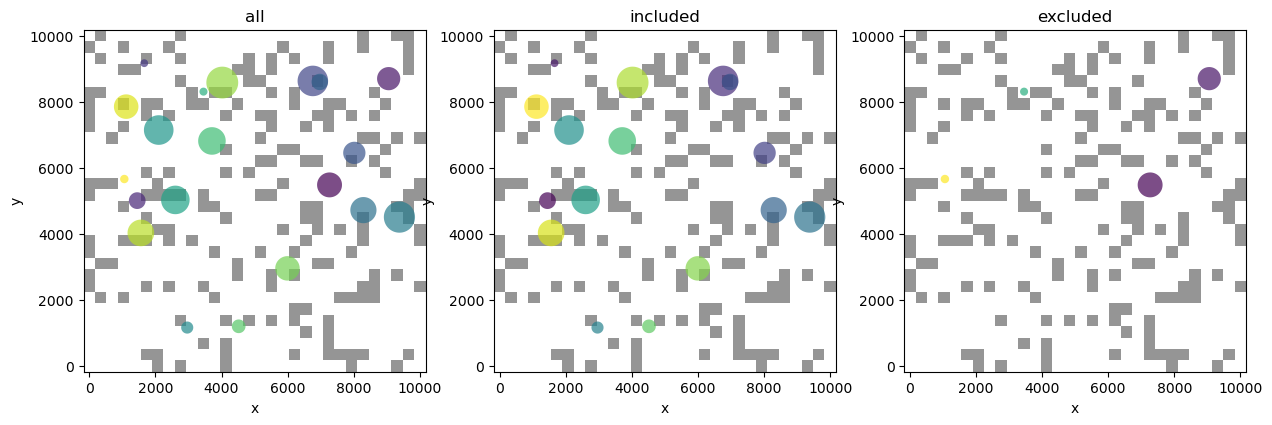

In [188]:

## make a random, binary raster
Z = np.random.random(size=(30,30))
Z = np.where(Z<0.8, np.nan, 1)

## and some x,y coordinates
x = np.linspace(0,10_000,30)
y = np.linspace(0,10_000,30)

# create crs aware xarray dataset
ds = xr.DataArray(data=Z,
                  dims=['y','x'],
                  coords={'x':(['x'],x),
                          'y':(['y'],y)}).rio.set_crs(27700)

# make some random circles within the bounds of the dataset
r = np.random.randint(100,500,20)
x0 = np.random.randint(r.max(), 10_000-r.max(), 20)
y0 = np.random.randint(r.max(), 10_000-r.max(), 20)

circles = [Point(x,y).buffer(r) for x,y,r in zip(x0,y0,r)]

# and convert to a geodataframe
gdf = gpd.GeoDataFrame(geometry=circles,crs=27700).reset_index()

## rasterize the geodataframe to a resolution higher than `ds`
## with each polygon given a unique value
rasterized_polygons = make_geocube(gdf, measurements=['index'], output_crs=27700, resolution=(10,10))

# reproject/resample ds to match that if the rasterized polygons
ds_rprj = ds.rio.reproject_match(rasterized_polygons)

# and multiply them, then get the unique values
# being a binary raster this will zero (or nan) out all of polygon indexes that don't intersect with your raster
unique = np.unique((ds_rprj * rasterized_polygons)['index'].values)

idx = unique[~np.isnan(unique)]

# identify indices of those to to exclude
not_idx = [i for i in gdf.index if i not in idx]


fig, axs = plt.subplots(figsize=[15,5],ncols=3)
for ax in axs:
    ds.plot(ax=ax,cmap='Greys', add_colorbar=False)

gdf.plot(ax=axs[0],column='index', alpha=0.7)
gdf.loc[idx].plot(ax=axs[1],column='index', alpha=0.7)
gdf.loc[not_idx].plot(ax=axs[2],column='index', alpha=0.7)

axs[0].set_title('all')
axs[1].set_title('included')
axs[2].set_title('excluded')

print(f"out of {len(gdf)}, only {len(idx)} are contain some 'grey' regions")